In [1]:
import sys
sys.path.append("../")

In [2]:
import os.path as op
import random

import matplotlib.pyplot as plt
import pandas as pd
import yaml

from agents import GreedyAgent,RandomAgent
from agents.matchmanager import MatchManager
from agents.ml.classifier import ClassifierAgent
from agents.ml.regression import RegressionAgent
from core.const import RED, BLUE
from core.game.state import vectorStateInfo, vectorState, vectorActionInfo, vectorAction
from scenarios import scenarioJunction

from multiprocessing import Pool

from itertools import product
import json

import os


%matplotlib inline
plt.rcParams['figure.figsize'] = (12,4)

In [3]:
with open(op.join('.', '../logger.config.yaml'), 'r') as stream:
    config = yaml.load(stream, Loader=yaml.FullLoader)
# logging.config.dictConfig(config)

In [4]:
def player(team:str, data:tuple, seed:int):
    if data[0] == 'gre':
        print(f'{team:5}-> GreedyAgent')
        return GreedyAgent(team, seed=seed)
    if data[0] == 'cls':
        print(f'{team:5}-> ClassifierAgent')
        return ClassifierAgent(team, data[1], seed=seed)
    if data[0] == 'reg':
        print(f'{team:5}-> RegressionAgent')
        return RegressionAgent(team, data[1], seed=seed)
    if data[0]=='ran':
        print(f'{team:5}-> RandomAgent')
        return RandomAgent(team, seed=seed)
        
    
    return None

In [5]:
def gameJunction(seed:int, red:tuple, blue:tuple) -> MatchManager:
    board, state = scenarioJunction()
    
    print('seed:   ', seed)
    
    playerRed = player(RED, red, seed)
    playerBlue = player(BLUE, blue, seed)

    mm = MatchManager(' ', playerRed, playerBlue, board, state, seed=seed)
    while not mm.end:
        mm.nextStep()
    
    print('winner: ', mm.winner)

    return mm

In [6]:
def game(args):
    scenario,seed,agentRed,agentBlue=args

    board, state = scenario()
    
    print('seed:   ', seed)
    
    playerRed = player(RED, agentRed, seed)
    playerBlue = player(BLUE, agentBlue, seed)

    mm = MatchManager(' ', playerRed, playerBlue, board, state, seed=seed)
    while not mm.end:
        mm.nextStep()
    save={
        'scenario':board.name,
        'seed':seed,
        'teamRed':playerRed.name,
        'teamBlue':playerBlue.name,
        'winner':mm.winner
    }
    file_name=f'../output/{playerRed.name}_{playerBlue.name}_{board.name}_{seed}.json'
    #print(file_name)
    with open(file_name, 'w') as json_file:
        json.dump(save, json_file)
        #salva le cose su disco!
    
    #print('winner: ', mm.winner)

    #return mm

In [7]:
def prepareDataFrames(mm:MatchManager):
    df_states = pd.DataFrame(
        columns=vectorStateInfo(),
        data=[vectorState(x) for x in mm.states_history]
    )

    df_actions = pd.DataFrame(
        columns=vectorActionInfo(),
        data=[vectorAction(x) for x in mm.actions_history]
    )
    df_red = mm.red.createDataFrame()
    df_blue = mm.blue.createDataFrame()
    
    df_red = df_red.set_index('count')
    df_blue = df_blue.set_index('count')

    return df_red, df_blue, df_states, df_actions

In [8]:
def plotEntropy(df, color:str):
    plt.figure()
    df.score.plot(color=color, marker='.')
    df.entropy.plot(color='purple')

    for i, row in df[['score','action']].reset_index().iterrows():
        dy, ha, va = (-0, 'center', 'top') if 'Respond' in row.action else (10, 'center', 'bottom')
        plt.annotate(row.action, (row['count'], row.score), ha=ha, va=va, rotation=90, textcoords="offset points", xytext=(0,dy))
        
    for x in df[['turn']].reset_index().groupby('turn').max().values.tolist():
        plt.axvline(x=x[0]+0.5, color='orange')

In [9]:
def plotContrast(df):
    df[df['team']=='red']['entropy'].plot(color='red'), df[df['team']=='blue']['entropy'].plot(color='blue')

In [10]:
def playAndAnalyze(seed:int, red_data, blue_data):  
    mm = gameJunction(seed, red_data, blue_data)
        
    df_red, df_blue, _, _ = prepareDataFrames(mm)
    
    plotEntropy(df_red, 'red')
    plotEntropy(df_blue, 'blue')
    
    return df_red, df_blue

In [ ]:
seed=51

In [ ]:
red_models = [
    ('gre', ''),
    ('cls', '../models/Junction_RandomForestClassifier_red.joblib'),
    ('cls', '../models/Junction_RandomForestClassifier.joblib'),
    ('reg', '../models/Junction_RandomForestRegressor_red.joblib'),
    ('reg', '../models/Junction_RandomForestRegressor.joblib'),
    ('ran','')
]
blue_models = [
    ('gre', ''),
    ('cls', '../models/Junction_RandomForestClassifier_blue.joblib'),
    ('cls', '../models/Junction_RandomForestClassifier.joblib'),
    ('reg', '../models/Junction_RandomForestRegressor_blue.joblib'),
    ('reg', '../models/Junction_RandomForestRegressor.joblib'),
    ('ran','')

]

args=[]
scenarios = [scenarioJunction]

for i in range(0,1):
    for scenario in scenarios:
        s = random.randint(0, 1000000)
        r = random.randint(0, len(red_models)-1)
        b = random.randint(0, len(blue_models)-1)
        args.append((scenario,s,red_models[r],blue_models[b]))

with Pool(64,maxtasksperchild=10) as p:
    p.map(game, args)

In [ ]:
scenarios = [scenarioJunction]
args=[]
for i in range(0, 100):
    for scenario in scenarios:
        for agentRed, agentBlue in product(red_models, blue_models):
            #s = random.randint(0, 1000000)
            args.append((scenario,i,agentRed,agentBlue))

In [ ]:
with Pool(64,maxtasksperchild=10) as p:
    p.map(game, args)

In [11]:
red_models = [
    ('gre', ''),
    ('cls', '../models/Junction_RandomForestClassifier_red.joblib'),
    ('cls', '../models/Junction_RandomForestClassifier.joblib'),
    ('reg', '../models/Junction_RandomForestRegressor_red.joblib'),
    ('reg', '../models/Junction_RandomForestRegressor.joblib'),
]
blue_models = [
    ('gre', ''),
    ('cls', '../models/Junction_RandomForestClassifier_blue.joblib'),
    ('cls', '../models/Junction_RandomForestClassifier.joblib'),
    ('reg', '../models/Junction_RandomForestRegressor_blue.joblib'),
    ('reg', '../models/Junction_RandomForestRegressor.joblib'),

]

seed:    749054
red  -> ClassifierAgent
blue -> RegressionAgent


No actions available: no response given
No actions available: no response given


winner:  blue


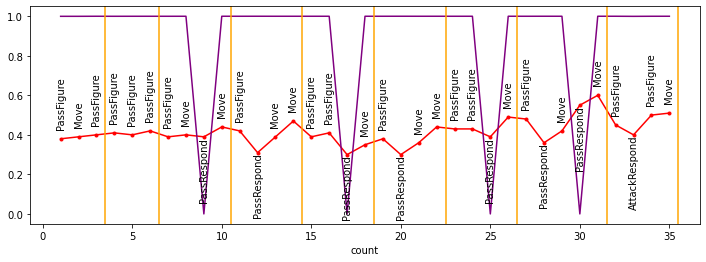

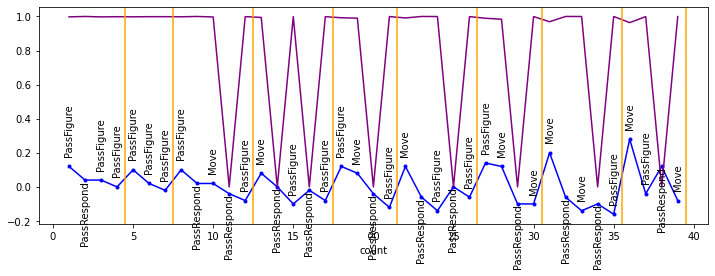

In [12]:
s = random.randint(0, 1000000)
r = random.randint(0, len(red_models)-1)
b = random.randint(0, len(blue_models)-1)

playAndAnalyze(s, red_models[r], blue_models[b]);

seed:    843552
red  -> ClassifierAgent
blue -> GreedyAgent


No actions available: no response given


winner:  blue


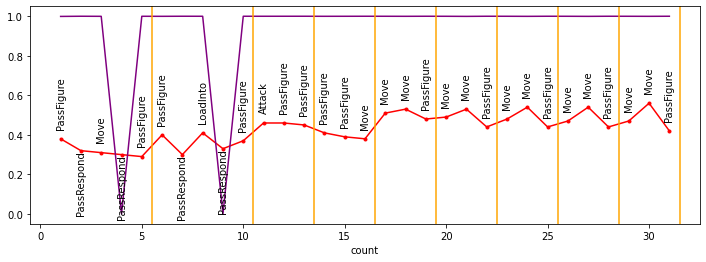

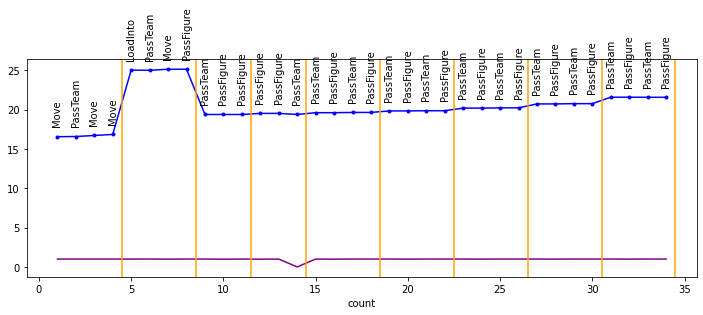

In [13]:
s = random.randint(0, 1000000)
r = random.randint(0, len(red_models)-1)
b = random.randint(0, len(blue_models)-1)

playAndAnalyze(s, red_models[r], blue_models[b]);

In [16]:
import warnings

seed:    893598
red  -> GreedyAgent
blue -> ClassifierAgent
winner:  red


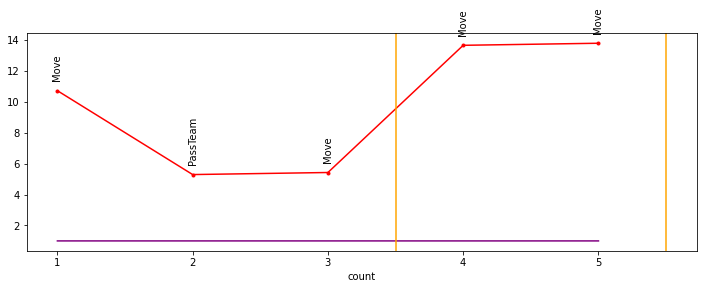

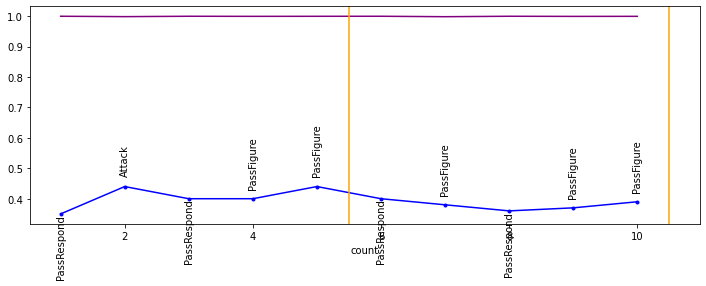

In [17]:
s = random.randint(0, 1000000)
r = random.randint(0, len(red_models)-1)
b = random.randint(0, len(blue_models)-1)

playAndAnalyze(s, red_models[r], blue_models[b]);

In [ ]:
s = random.randint(0, 1000000)
r = random.randint(0, len(red_models)-1)
b = random.randint(0, len(blue_models)-1)

playAndAnalyze(s, red_models[r], blue_models[b]);